<a href="https://colab.research.google.com/github/CobaMasa/PythonKerasDeeplearning/blob/main/chapter6_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6-3:Advanced usage of RNN

In [1]:
## Set this parametor for switching the path for online or ofline
# switch path whether (where) you're editing this notebook online or ofline
import os
from google.colab import drive

online = True

if online:
    drive.mount('/content/drive')
    data_dir = 'drive/My Drive/Study/PythonKeras/data/jena_climate'

else:
    data_dir = '/Users/kobayashimasahiro/Google Drive File Stream/マイドライブ/Study/PythonKeras/data/jena_climate'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# List 6-28: Check weather data
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
with open(fname, 'r') as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('header: ', header)
print('lines: ', len(lines))

header:  ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
lines:  420551


In [3]:
# List 6-29: Analysis of data
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(value) for value in line.split(',')[1:]]
    float_data[i, :] = values

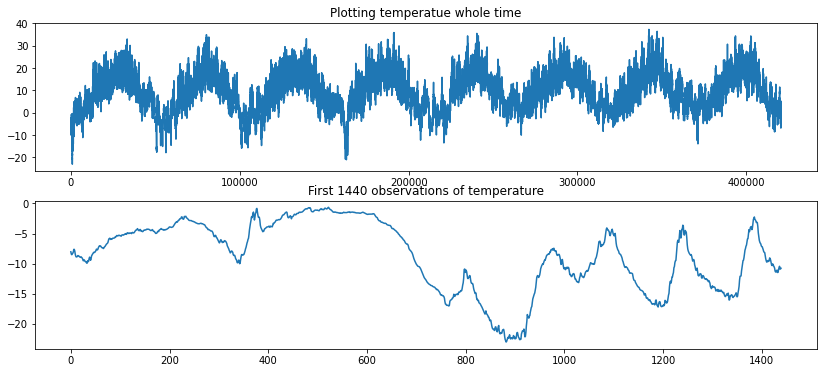

In [4]:
# List 6-30&31: Plot the result
import matplotlib.pyplot as plt
fig, ax  = plt.subplots(2, 1, figsize=(14, 6))
temp = float_data[:, 1]

# about List 6-30
ax[0].plot(range(len(temp)), temp)
ax[0].set_title('Plotting temperatue whole time')

# about List 6-31 (plot the first 1440 temperatures)
ax[1].plot(range(1440), temp[:1440])
ax[1].set_title('First 1440 observations of temperature')
plt.show();

In [5]:
# List 6-32: NStandardize data
## Just use the first 200000 points
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)
float_data -= mean
float_data /= std

'''
I dont know why but this calcrate use the first 200000 data for standardization
and apply it on WHOLE dataset (which means 'float_data').
'''

"\nI dont know why but this calcrate use the first 200000 data for standardization\nand apply it on WHOLE dataset (which means 'float_data').\n"

In [6]:
# List 6-33: Define the generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        
        else:
            if (i+batch_size) >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [7]:
# List 6-34: Prepares generators of data
lookback = 1440
step = 6
delay = 144
batch_size = 128
some_args = {'lookback': lookback, 'delay': delay, 'batch_size': batch_size, 'step': step}

train_gen  = generator(float_data, min_index=0, max_index=200000, shuffle=True, **some_args)
val_gen = generator(float_data, min_index=200001, max_index=300000, **some_args)
test_gen = generator(float_data, min_index=300001, max_index=None, **some_args)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Baseline without ML

In [8]:
# List 6-35: define calcurate MAEs as baseline
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print('batch_mean of MAEs: ', np.mean(batch_maes))

evaluate_naive_method()

batch_mean of MAEs:  0.2897359729905488


In [9]:
# List 6-36: Transform MAE into error
celsius_mae = 0.2897 * std[1]
print(celsius_mae)

2.5645689841146764


## Baseline with ML

In [10]:
# List 6-37: Fully-conneceted model (this might fail when runnig on my PC due to memory lack)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

inputs = Input(shape=(lookback//step, float_data.shape[-1]))
x = Flatten()(inputs)
x = Dense(32, activation='relu')(x)
prediction = Dense(1)(x) # No need set activation cuz we wanna predict temperature, which is continuus valu

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.6360 - val_loss: 0.9642
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.6161 - val_loss: 0.4218
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3400 - val_loss: 0.3020
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2864 - val_loss: 0.3344
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2681 - val_loss: 0.3000
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2538 - val_loss: 0.3430
Epoch 7/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2461 - val_loss: 0.3156
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2386 - val_loss: 0.3537
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2311 - val_loss: 0.3213
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.227

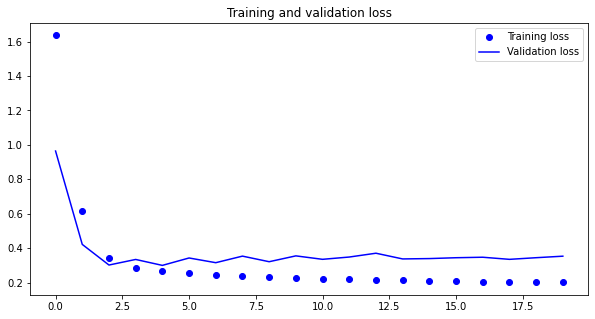

In [11]:
# List 6-38: Plot the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

## First Reccurent Baseline

In [12]:
# List 6-39: Train and validate model
from tensorflow.keras.layers import GRU

inputs = Input(shape=(None, float_data.shape[-1]))
x = GRU(32)(inputs)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3028 - val_loss: 0.2703
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2820 - val_loss: 0.2663
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2776 - val_loss: 0.2764
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2711 - val_loss: 0.2625
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2685 - val_loss: 0.2633
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2658 - val_loss: 0.2730
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2613 - val_loss: 0.2673
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2564 - val_loss: 0.2706
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2525 - val_loss: 0.2679
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.247

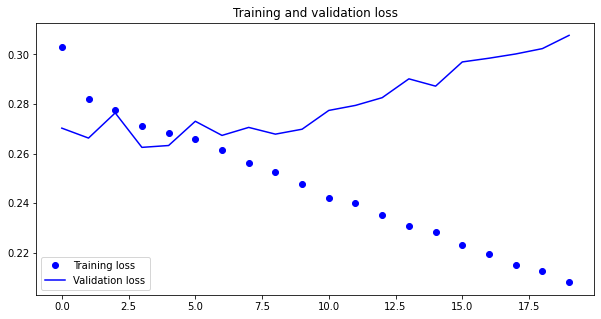

In [13]:
# Plot the result
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

## Apply Dropout

In [14]:
# List 6-40: Train new model with regularization
inputs = Input(shape=(None, float_data.shape[-1]))
x = GRU(32, dropout=0.2, recurrent_dropout=0.2)(inputs)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
##↓↓Too heavy for my PC. Do it before diiving into the bed
## history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
 89/500 [====>.........................] - ETA: 4:53 - loss: 0.3575

KeyboardInterrupt: ignored

In [ ]:
# Plot the result
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

## Do stacking

In [15]:
inputs = Input(shape=(None, float_data.shape[-1]))
x = GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = GRU(64, dropout=0.1, recurrent_dropout=0.5, activation='relu')(x)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
##↓↓Too heavy for my PC. Do it before diiving into the bed
### hisotry = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
# Plot the result
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

## Bidirectional RNN

In [16]:
# Optional: How to use tf.keras.preprocessing.sequence.pad_sequences
from tensorflow.keras.preprocessing import sequence
iterations = [np.arange(i+1) for i in range(10)]
default = sequence.pad_sequences(iterations)
print('- default')
display(default) # zero padding along with the longest array
co5 = sequence.pad_sequences(iterations, maxlen=5, truncating='post')
print('- cut over 5')
display(co5)

- default


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 2, 3],
       [0, 0, 0, 0, 0, 0, 1, 2, 3, 4],
       [0, 0, 0, 0, 0, 1, 2, 3, 4, 5],
       [0, 0, 0, 0, 1, 2, 3, 4, 5, 6],
       [0, 0, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int32)

- cut over 5


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 2],
       [0, 0, 1, 2, 3],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]], dtype=int32)

In [17]:
# List 6-42: Inverse trick of sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

inputs = Input(shape=(None, ))
x = Embedding(max_features, 128)(inputs)
x = LSTM(32)(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 51ms/step - loss: 0.5008 - acc: 0.7589 - val_loss: 0.4437 - val_acc: 0.8370
Epoch 2/10
157/157 [==============================] - 8s 48ms/step - loss: 0.3144 - acc: 0.8776 - val_loss: 0.3406 - val_acc: 0.8534
Epoch 3/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2570 - acc: 0.9014 - val_loss: 0.5208 - val_acc: 0.7906
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2132 - acc: 0.9202 - val_loss: 0.3371 - val_acc: 0.8866
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1845 - acc: 0.9348 - val_loss: 0.3477 - val_acc: 0.8802
Epoch 6/10
157/157 [==============================] - 7s 47ms/step - loss: 0.1660 - acc: 0.9391 - val_loss: 0.4115 - val_acc: 0.8700
Epoch 7/10
157/157 [==============================] - 7s 46ms/step - loss: 0.1463 - acc: 0.9490 - val_loss: 0.3701 - val_acc: 0.8686
Epoch 8/10
157/157 [==============================] - 7s 47ms/step - 

In [18]:
# List 6-43: Build bidirectional RNN
from tensorflow.keras.layers import Bidirectional

inputs = Input(shape=(None, ))
x = Embedding(max_features, 32)(inputs)
x = Bidirectional(LSTM(32))(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 53ms/step - loss: 0.5412 - acc: 0.7344 - val_loss: 0.6627 - val_acc: 0.7776
Epoch 2/10
157/157 [==============================] - 8s 48ms/step - loss: 0.3389 - acc: 0.8699 - val_loss: 0.3379 - val_acc: 0.8598
Epoch 3/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2704 - acc: 0.8989 - val_loss: 0.2921 - val_acc: 0.8928
Epoch 4/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2307 - acc: 0.9176 - val_loss: 0.3211 - val_acc: 0.8770
Epoch 5/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2065 - acc: 0.9283 - val_loss: 0.3151 - val_acc: 0.8696
Epoch 6/10
157/157 [==============================] - 8s 48ms/step - loss: 0.1830 - acc: 0.9366 - val_loss: 0.6866 - val_acc: 0.7640
Epoch 7/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1657 - acc: 0.9435 - val_loss: 0.3303 - val_acc: 0.8786
Epoch 8/10
157/157 [==============================] - 8s 50ms/step - 

In [19]:
############ Delete this code after runnnig ####################

# List 6-43: + alpha
# if we use Sequential() making a model
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 54ms/step - loss: 0.6059 - acc: 0.6742 - val_loss: 0.6100 - val_acc: 0.6510
Epoch 2/10
157/157 [==============================] - 8s 48ms/step - loss: 0.4028 - acc: 0.8421 - val_loss: 0.3353 - val_acc: 0.8698
Epoch 3/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2976 - acc: 0.8870 - val_loss: 0.3751 - val_acc: 0.8558
Epoch 4/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2502 - acc: 0.9103 - val_loss: 0.3160 - val_acc: 0.8874
Epoch 5/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2133 - acc: 0.9233 - val_loss: 0.3596 - val_acc: 0.8774
Epoch 6/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1929 - acc: 0.9301 - val_loss: 0.8559 - val_acc: 0.8292
Epoch 7/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1743 - acc: 0.9405 - val_loss: 0.3678 - val_acc: 0.8808
Epoch 8/10
157/157 [==============================] - 8s 48ms/step - 

In [28]:
# List 6-44: Train bidirectional RNN with GRU (applied data was about the weather)
inputs = Input(shape=(None, float_data.shape[-1]))
x = Bidirectional(GRU(32))(inputs)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer='rmsprop', loss='mae')
##↓↓Too heavy for my PC. Do it before diiving into the bed
### history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
50/50 [==============================] - 12s 245ms/step - loss: 0.3859 - val_loss: 0.2933
Epoch 2/40
50/50 [==============================] - 12s 243ms/step - loss: 0.3060 - val_loss: 0.2886
Epoch 3/40
50/50 [==============================] - 12s 234ms/step - loss: 0.2968 - val_loss: 0.2857
Epoch 4/40
50/50 [==============================] - 12s 232ms/step - loss: 0.2962 - val_loss: 0.2814
Epoch 5/40
50/50 [==============================] - 12s 230ms/step - loss: 0.2902 - val_loss: 0.2736
Epoch 6/40
50/50 [==============================] - 12s 232ms/step - loss: 0.2898 - val_loss: 0.2741
Epoch 7/40
50/50 [==============================] - 12s 233ms/step - loss: 0.2853 - val_loss: 0.2739
Epoch 8/40
50/50 [==============================] - 12s 230ms/step - loss: 0.2807 - val_loss: 0.2701
Epoch 9/40
50/50 [==============================] - 12s 233ms/step - loss: 0.2833 - val_loss: 0.2673
Epoch 10/40
50/50 [==============================] - 12s 232ms/step - loss: 0.2855 - val_lo